Processing country: USA
Starting attack and evaluation for perturbation level 0.0%
Perturbation level: 0.0%
Test Accuracy: 0.4916
---
Starting attack and evaluation for perturbation level 5.0%
Perturbation level: 5.0%
Test Accuracy: 0.4246
---
Starting attack and evaluation for perturbation level 10.0%
Perturbation level: 10.0%
Test Accuracy: 0.4581
---
Starting attack and evaluation for perturbation level 15.0%
Perturbation level: 15.0%
Test Accuracy: 0.4581
---
Starting attack and evaluation for perturbation level 20.0%
Perturbation level: 20.0%
Test Accuracy: 0.4469
---
Starting attack and evaluation for perturbation level 25.0%
Perturbation level: 25.0%
Test Accuracy: 0.4749
---
Processing country: Brazil
Starting attack and evaluation for perturbation level 0.0%
Perturbation level: 0.0%
Test Accuracy: 0.3000
---
Starting attack and evaluation for perturbation level 5.0%
Perturbation level: 5.0%
Test Accuracy: 0.2500
---
Starting attack and evaluation for perturbation level 10.0%
P

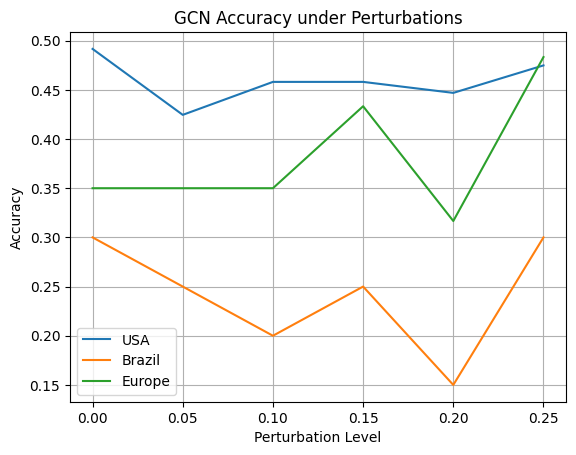

In [30]:
# Install necessary libraries
!pip install torch torch_geometric scipy numpy scikit-learn networkx pandas matplotlib

# Define necessary imports and device setup
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch_geometric.datasets import Airports
from torch_geometric.utils import to_scipy_sparse_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define GCN model and graph convolution layer
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        return output

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

# Define utility functions
def load_airports_data(country):
    dataset = Airports(root='/tmp/Airports', name=country)
    data = dataset[0]
    adj = to_scipy_sparse_matrix(data.edge_index)
    features = data.x.to(device)
    labels = data.y.to(device)
    return adj, features, labels

def preprocess(adj, features, labels, preprocess_adj=True, preprocess_feature=True, sparse=False):
    if preprocess_adj:
        adj = adj + sp.eye(adj.shape[0])
    if preprocess_feature:
        features = features / features.sum(1, keepdims=True)
    if sparse:
        adj = sp.coo_matrix(adj)
        adj = torch.sparse.FloatTensor(
            torch.LongTensor([adj.row, adj.col]),
            torch.FloatTensor(adj.data),
            torch.Size(adj.shape)
        ).to(device)
    else:
        adj = torch.FloatTensor(np.array(adj.todense())).to(device)
    features = torch.FloatTensor(np.array(features.cpu())).to(device)
    labels = torch.LongTensor(labels.cpu()).to(device)
    return adj, features, labels

def get_train_val_test(idx, train_size, val_size, test_size, stratify=None):
    idx_train, idx_test = train_test_split(idx, train_size=train_size, test_size=test_size, stratify=stratify)
    idx_train, idx_val = train_test_split(idx_train, train_size=(train_size / (train_size + val_size)), test_size=(val_size / (train_size + val_size)), stratify=stratify[idx_train] if stratify is not None else None)
    return idx_train, idx_val, idx_test

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

# Define Meta class for attack and evaluation
class Meta:
    def __init__(self, adj, features, labels, idx_train, idx_val, idx_test, nfeat, nhid, nclass, dropout, lr, weight_decay, patience, epochs, device):
        self.adj = adj.to(device)
        self.features = features.to(device)
        self.labels = labels.to(device)
        self.idx_train = torch.LongTensor(idx_train).to(device)
        self.idx_val = torch.LongTensor(idx_val).to(device)
        self.idx_test = torch.LongTensor(idx_test).to(device)
        self.nfeat = nfeat
        self.nhid = nhid
        self.nclass = nclass
        self.dropout = dropout
        self.lr = lr
        self.weight_decay = weight_decay
        self.patience = patience
        self.epochs = epochs
        self.device = device
        self.gcn = GCN(nfeat=nfeat, nhid=nhid, nclass=nclass, dropout=dropout).to(device)
        self.optimizer = optim.Adam(self.gcn.parameters(), lr=lr, weight_decay=weight_decay)
        self.criterion = nn.NLLLoss().to(device)

    def train_gcn(self):
        best_val_loss = float('inf')
        best_model = None
        patience_counter = 0

        for epoch in range(self.epochs):
            self.gcn.train()
            self.optimizer.zero_grad()
            output = self.gcn(self.features, self.adj)
            loss_train = self.criterion(output[self.idx_train], self.labels[self.idx_train])
            loss_train.backward()
            self.optimizer.step()

            self.gcn.eval()
            output = self.gcn(self.features, self.adj)
            loss_val = self.criterion(output[self.idx_val], self.labels[self.idx_val])
            acc_val = accuracy(output[self.idx_val], self.labels[self.idx_val])

            if loss_val < best_val_loss:
                best_val_loss = loss_val
                best_model = self.gcn.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.patience:
                break

        self.gcn.load_state_dict(best_model)
        return self.gcn

    def evaluate_gcn(self, model):
        model.eval()
        output = model(self.features, self.adj)
        loss_test = self.criterion(output[self.idx_test], self.labels[self.idx_test])
        acc_test = accuracy(output[self.idx_test], self.labels[self.idx_test])
        return loss_test.item(), acc_test

    def perturb_adj(self, perturbation):
        np.random.seed(42)
        num_edges = int(self.adj.sum() / 2)
        num_perturb = int(num_edges * perturbation)

        modified_adj = self.adj.clone()
        all_edges = np.array(np.triu_indices(self.adj.shape[0], k=1)).T

        np.random.shuffle(all_edges)
        perturbed_edges = all_edges[:num_perturb]

        for edge in perturbed_edges:
            modified_adj[edge[0], edge[1]] = 1 - modified_adj[edge[0], edge[1]]
            modified_adj[edge[1], edge[0]] = 1 - modified_adj[edge[1], edge[0]]

        return modified_adj.to(self.device)

def run_attack_and_evaluate(countries, perturbation_levels, seed=42):
    results = {}

    for country in countries:
        print(f"Processing country: {country}")
        adj, features, labels = load_airports_data(country)
        n_nodes, n_features = features.shape
        n_classes = len(set(labels.cpu().numpy()))
        idx = np.arange(n_nodes)
        idx_train, idx_val, idx_test = get_train_val_test(idx, 0.7, 0.1, 0.15, stratify=labels.cpu().numpy())

        adj, features, labels = preprocess(adj, features, labels)

        meta = Meta(adj, features, labels, idx_train, idx_val, idx_test, nfeat=n_features, nhid=64, nclass=n_classes, dropout=0.5,
                    lr=0.01, weight_decay=5e-4, patience=100, epochs=500, device=device)

        results[country] = {'perturbation_results': {}}

        for perturbation in perturbation_levels:
            print(f"Starting attack and evaluation for perturbation level {perturbation * 100:.1f}%")
            perturbed_adj = meta.perturb_adj(perturbation)
            meta.adj = perturbed_adj  # Update the adjacency matrix in the meta object
            model = meta.train_gcn()
            loss_test, acc_test = meta.evaluate_gcn(model)

            print(f"Perturbation level: {perturbation * 100:.1f}%")
            print(f"Test Accuracy: {acc_test.cpu().item():.4f}")
            print("---")

            results[country]['perturbation_results'][perturbation] = acc_test.cpu().item()

    return results

def save_results_to_csv(results, filename):
    data = []
    for country, country_results in results.items():
        for perturbation, acc in country_results['perturbation_results'].items():
            data.append([country, perturbation, acc])

    df = pd.DataFrame(data, columns=['Country', 'Perturbation', 'Accuracy'])
    df.to_csv(filename, index=False)

def plot_accuracies(results):
    for country, country_results in results.items():
        perturbations = sorted(country_results['perturbation_results'].keys())
        accuracies = [country_results['perturbation_results'][p] for p in perturbations]

        plt.plot(perturbations, accuracies, label=country)

    plt.xlabel('Perturbation Level')
    plt.ylabel('Accuracy')
    plt.title('GCN Accuracy under Perturbations')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example of how to run the functions
countries = ['USA', 'Brazil', 'Europe']
perturbation_levels = [0, 0.05, 0.1, 0.15, 0.2, 0.25]
results = run_attack_and_evaluate(countries, perturbation_levels, seed=42)
save_results_to_csv(results, 'results.csv')
plot_accuracies(results)
